In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pyodbc
import json

# Past Delta Analysis

This notebook will look at trends in past scrapes, in order to create a better predictive model to find what pages to scrape.

In [2]:
# Setup SQL
global con, cur
with open(r"../sql-config.json") as f:
    sql_config = json.load(f)
con = pyodbc.connect(
    "Driver={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.0.so.1.1};"
    "TrustServerCertificate=yes;"
    f"Server={sql_config['ip']},{sql_config['port']};"
    f"Database={sql_config['database']};"
    f"UID={sql_config['uid']};"
    f"PWD={sql_config['password']};"
)
cur = con.cursor()

In [3]:
# Pull all data from FatTrimmerData into df
df = pd.DataFrame()
sql = "SELECT * FROM FatTrimmerData;"
for chunk in pd.read_sql(sql, con, chunksize=10000):
    df = pd.concat([df, chunk])

/home/andy/.local/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [2]:
df = pd.DataFrame()
for chunk in pd.read_csv(r"fat_trimmer_data.csv", chunksize=10000):
    df = pd.concat([df, chunk])

In [ ]:
# export csv
df.to_csv(r"fat_trimmer_data.csv")

In [3]:
# Remove outliers
df = df[(np.abs(stats.zscore(df["DeltaTime"])) < 3)]

In [4]:
df.head()

,Unnamed: 0,NewItems,PageNumber,DeltaTime,Batch
0,0,False,580,2370000,145480
1,1,False,580,4489000,145602
2,2,False,580,5688000,145748
3,3,False,580,5103000,145874
4,4,False,580,7057000,146074


In [5]:
df.describe()

,Unnamed: 0,PageNumber,DeltaTime,Batch
count,558544.000000,558544.000000,5.585440e+05,558544.000000
mean,4979.015949,896.962007,7.977651e+06,117369.459085
std,2889.670943,518.105603,7.613262e+06,43149.442213
min,0.000000,0.000000,-9.000000e+03,1717.000000
25%,2473.000000,448.000000,3.453000e+06,95202.000000
50%,4966.000000,897.000000,4.939000e+06,129516.000000
75%,7483.000000,1346.000000,9.283000e+06,149254.000000
max,9999.000000,1816.000000,4.403500e+07,172495.000000


In [6]:
df.shape

(558544, 5)

# Graphs of data below

**Outliers were removed for the purpose of easier viewing**

[Text(0.5, 1.0, 'Distribution of pages with and without new items \nbased on time between scrapes')]

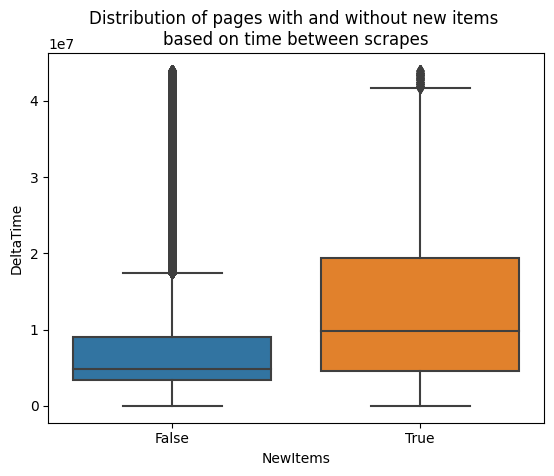

In [7]:
# Corelation between time between scrapes, and if that page had new items
sns.boxplot(
    x=df["NewItems"],
    y=df["DeltaTime"]
).set(title="Distribution of pages with and without new items \nbased on time between scrapes")

## Distribution of pages with and withoutnew items based on time between scrapes

It is clear that pages without new items have a consistently shorter scrape time, and in general a tighter distribution meaning more consistent scrape times.
The mean of pages with new items is similar to that of pages without, but it is sqewed more towards longer scrape times.

Due to the high number of outliers and the likelyhood of an unacounted variable affecting the results, this graph is inconclusive.

[Text(0.5, 1.0, 'Page number vs. time between scrapes \nfor bazos pages')]

/usr/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


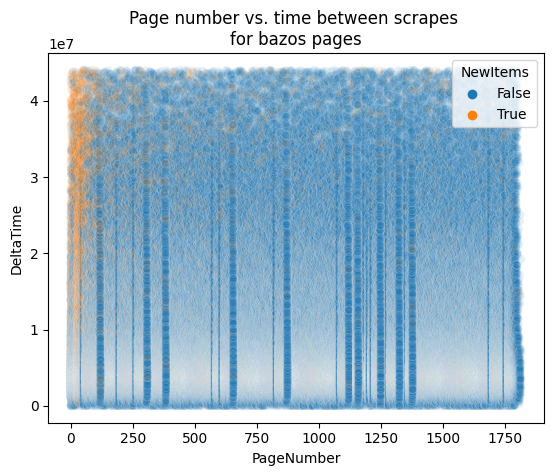

In [8]:
# scrape time vs. how common that page was
sns.scatterplot(
    x=df["PageNumber"],
    y=df["DeltaTime"],
    hue=df["NewItems"],
    alpha=0.1,
).set(title="Page number vs. time between scrapes \nfor bazos pages")

## Page number vs. time between scrapes for bazos pages

(note that you can only see 1/alpha points overlaid on top of eachother)

This graph clearly shows that the majority of pages with new items, have a very low page number. The time between scrapes does not seem to be a good indicator of if a particular page will have new or only old listings.

One unexplained curiosity are the dense vertical lines, there is no good explanation for this since the number of times each page was scanned is uniform as shown in later graphs.

[Text(0.5, 1.0, 'Page number vs time in between scrapes \nfor pages with new items')]

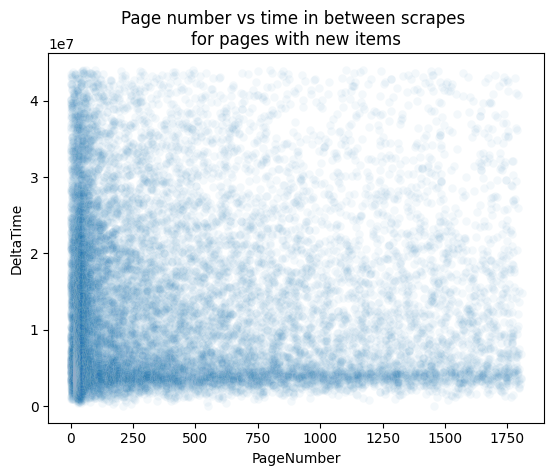

In [9]:
# scrape time vs. how common that page was, new items only
new_only = df[df.NewItems == True]
sns.scatterplot(
    x=new_only["PageNumber"],
    y=new_only["DeltaTime"],
    alpha=0.05,
).set(title="Page number vs time in between scrapes \nfor pages with new items")

## Page number vs time in between scrapes for pages with new items

This graph is very similar to the one above. Do not let the colours fool you, it is representing only the pages with new items.

Similar conclusions can be drawn from this representaiton, with the majority of pages with new listings having low page numbers.
A trend is revealed where higher page numbers which have new listings tend to have a consistent scrape delta at around 0.2. It is not clear if this is just a general trend of all pages regardless of listing status, or if it is correlated to new listings being found.

In [10]:
# Graph the amount of times each page was scraped
scan_num = df["PageNumber"].value_counts().to_frame(name="count")
scan_num.reset_index(inplace=True)
scan_num.rename({"index": "page"}, axis=1, inplace=True)
scan_num.describe()

,page,count
count,1816.000000,1816.000000
mean,907.500551,307.568282
std,524.379316,28.889373
min,0.000000,1.000000
25%,453.750000,310.000000
50%,907.500000,311.000000
75%,1361.250000,312.000000
max,1816.000000,318.000000


[Text(0.5, 1.0, 'Number of times each page was scanned')]

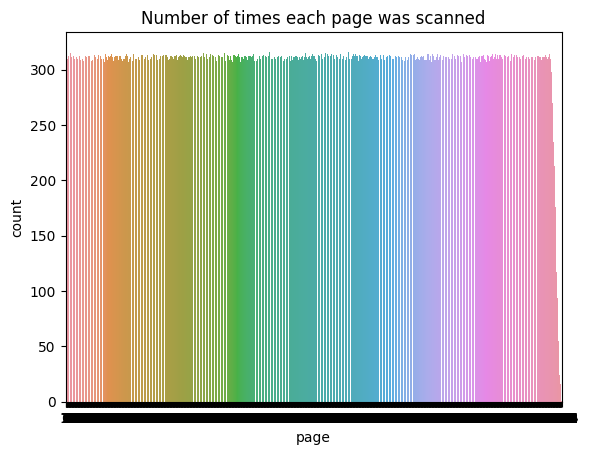

In [11]:
sns.barplot(
    data=scan_num,
    x="page",
    y="count",
).set(title="Number of times each page was scanned")

## Number of times each page was scanned

This visualisation shows the distribution of how often certain pages were scanned.

It is hard to create a sensible bar graph with this many bars, but it appears that the distribution is uniform.